# Q-learning для окружения Taxi

Описание домашнего задания:
* Возьмите среду Taxi из фреймворка gym: https://gymnasium.farama.org/environments/toy_text/taxi/.
* Определите и опишите какие у этой среды есть состояния и награды, а также какие действия можно совершать.
* Реализуйте один из алгоритмов поиска оптимальной стратегии: Value Iteration, Policy Iteration, Monte Carlo, SARSA, Q-learning.
* Получив оптимальную стратегию сыграйте 10 000 эпизодов и выведите оценку этой стратегии в виде средней награды за все игры и/или количество побед.
* Визуализируйте один эпизод игры с оптимальной стратегией.

In [1]:
import gymnasium as gym
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## 1. Описание окружения

Окружение такси представляет из себя сетку 5х5 с 4 пунктами назначения. Стоит задача подобрать пассажира из одного из 4 пунктов и привезти в другой требуемый пункт назначения. При asci-рендере точка забора пассажира окрашена в голубой цвет, точка высадки в красный. Начальное положение такси случайно.

Доступные действия:
* 0 - движение вниз
* 1 - движение вверх
* 2 - движение вправо
* 3 - движение влево
* 4 - подобрать пассажира
* 5 - высадить пассажира

Переход из одного состояния в другое имеет вероятность 1.
Награда за каждое движение -1. Награда за высадку пассажира в пункте назначения +20, награда за высадку пассажира в неправильном месте -10.

Всего в окружении 500 состояний: 25 позиций на сетке, 4 пункта назначения, 5 локаций пассажира (пункты назначения + само такси).
Эпизод заканчивается или при высадке пассажира в треюуемом пункте назаначения или при превышении числа эпизодов.

In [2]:
env = gym.make('Taxi-v3', render_mode='ansi', max_episode_steps=1000)
env.reset()

(388, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [3]:
env.observation_space.n, env.action_space.n

(500, 6)

In [4]:
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [5]:
env.env.P[0]

{0: [(1.0, 100, -1, False)],
 1: [(1.0, 0, -1, False)],
 2: [(1.0, 20, -1, False)],
 3: [(1.0, 0, -1, False)],
 4: [(1.0, 16, -1, False)],
 5: [(1.0, 0, -10, False)]}

In [6]:
final_states = []
for state in env.env.P.keys():
    for action in env.env.P[state]:
        if env.env.P[state][action][0][3] == True:
            final_states.append(state)
final_states

[16, 97, 418, 479]

В этом окружении финальные состояния достигаются только при одном из 6 действий. Поэтому в Q-таблице согласно алгоритму необходимо занулить только 4 значения.

In [7]:
env.env.P[16]

{0: [(1.0, 116, -1, False)],
 1: [(1.0, 16, -1, False)],
 2: [(1.0, 36, -1, False)],
 3: [(1.0, 16, -1, False)],
 4: [(1.0, 16, -10, False)],
 5: [(1.0, 0, 20, True)]}

## 2. Реализация алгоритма Q-learning

In [8]:
def get_random_Q(env):
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.random.random(size=(nS, nA))
    Q[final_states, 5] = 0.0
    return Q

def compute_policy_by_Q(env, Q):
    return np.argmax(Q, axis=1)

In [9]:
def learning_episode(env, policy, Q, alpha=0.1, epsiolon=0.1, gamma=0.9, max_epochs=1000):
    state, _ = env.reset()
    n_epochs, total_reward = 0, 0
    done = False
    for _ in range(max_epochs):
        action = policy[state] if np.random.rand() > epsilon else env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        Q[state, action] += alpha * (reward + gamma * Q[next_state].max() - Q[state, action])
        state = next_state
        n_epochs += 1
        if done:
            break
    return n_epochs, total_reward

### 2.1. Обучение

In [10]:
Q = get_random_Q(env)
policy = compute_policy_by_Q(env, Q)

n_episodes = 10000
gamma = 0.9
epsilon = 0.1
alpha = 0.1

epochs_per_eposode, reward_per_episode = [], []
for _ in tqdm(range(n_episodes)):
    n_epochs, total_reward = learning_episode(env, policy, Q, alpha, epsilon, gamma)
    epochs_per_eposode.append(n_epochs)
    reward_per_episode.append(total_reward)
    policy = compute_policy_by_Q(env, Q)

env.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

### 2.2. Визуализация обучения

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

В качестве визулизации наиболее наглядными будут усредненные награды по эпизодам и усредненное количество шагов, требуемых для достижения финального состояния.

In [12]:
rewards_dynamic = moving_average(reward_per_episode, 100)

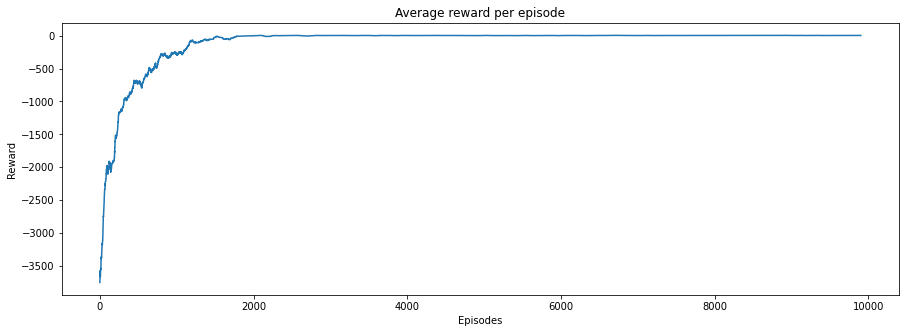

In [13]:
plt.figure(figsize=(15,5))
plt.plot(rewards_dynamic)
plt.title("Average reward per episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

In [14]:
nepochs_dynamic = moving_average(epochs_per_eposode, 100)

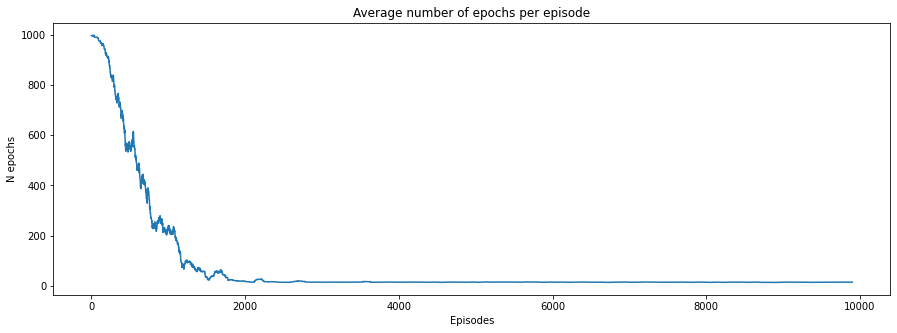

In [15]:
plt.figure(figsize=(15,5))
plt.plot(nepochs_dynamic)
plt.title("Average number of epochs per episode")
plt.xlabel("Episodes")
plt.ylabel("N epochs")
plt.show()

Как видно, оптимальная политика была получена уже после примерно 2000 эпизодов.

In [16]:
epochs_per_eposode[-10:]

[14, 13, 12, 11, 11, 7, 15, 16, 18, 13]

In [17]:
reward_per_episode[-10:]

[-2, -1, 9, 1, 10, 14, 6, 5, -6, 8]

In [43]:
epochs_per_eposode = np.asarray(epochs_per_eposode)

In [47]:
np.where(epochs_per_eposode < 1000)[0].shape

(9424,)

В качестве оценки успешности алгоритма вряд ли будет показательно количество успешных эпизодов, т.к. нет прочих терминальных состояний, а мы даем слишком много попыток достичь результата. В итоге 94% всех эпизодов заканчиваются "успешно".

## 3. Тестирование политики

Проиграем один эпизод на оптимальной политике.

In [33]:
state, _ = env.reset()

done = False
history = [env.render()]
test_reward, test_n_epochs = 0, 0

while not done:
    action = policy[state]
    state, reward, done, _, _ = env.step(action)
    test_reward += reward
    test_n_epochs += 1
    history.append(env.render())

In [34]:
test_reward, test_n_epochs

(8, 13)

В качестве визуализации подойдет вывод рендеров эпизода

In [35]:
for x in history:
    print(x)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|